In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sys
import random
import os
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
sys.path.append('../utils')

In [4]:
SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [5]:
from training_nn import training_rnn, training
from evaluation import evaluate_model, plot_loss, evaluate_model_rnn
from process_data import get_desc, get_data
from models import CNN, RNNembed, RNN
from dataset import Abencode1, Abencode2, Onehot, OnehotandAB

In [7]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [8]:
train = pd.read_csv(train_path)

In [9]:
test = pd.read_csv(test_path)

In [10]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [11]:
train_target, valid_target, target_test, _ = get_data(train, test, target_ab='REGN33')

In [25]:
def prepare_dataloader(df, dataset_torch, batch_size=5, shuffle=True):
    dataset = dataset_torch(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [13]:
validloader = prepare_dataloader(valid_target, Abencode1, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Abencode1, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Abencode1, shuffle=False, batch_size=50)

CNN model training

In [19]:
model = CNN(41, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader_target,
                                            validloader)

100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


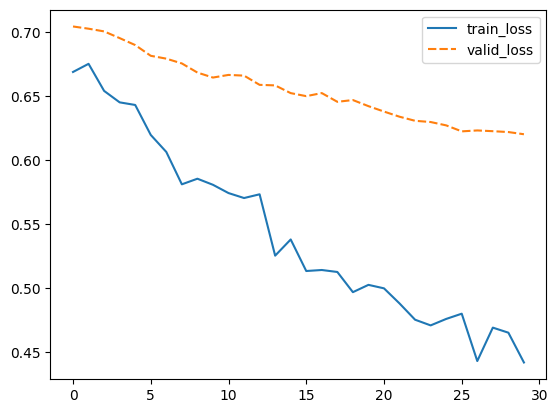

In [20]:
plot_loss(loss_train_hist, loss_valid_hist)

REGN33 Escape prediction: classification metrics using RBD mutant sequences (physical features encoded) СNN trained model on 100 points

In [21]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.577225,0.174187,0.893846,0.291557,0.79425


In [14]:
validloader = prepare_dataloader(valid_target, Abencode2, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Abencode2, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Abencode2, shuffle=False, batch_size=50)

RNN training

In [16]:
model = RNNembed().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target,
                                                validloader)

100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


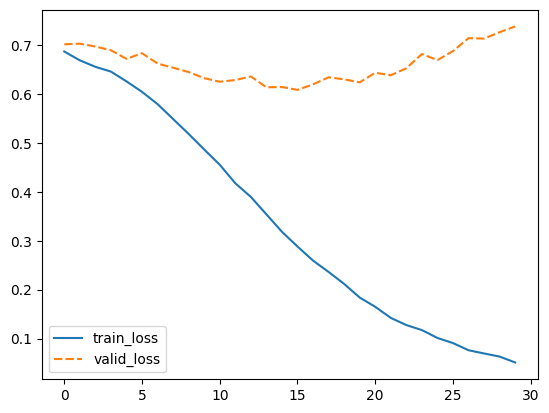

In [17]:
plot_loss(loss_train_hist, loss_valid_hist)

REGN33 Escape prediction: classification metrics using RBD mutant sequences (physical features encoded) RNN trained model on 100 points

In [18]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.717302,0.633488,0.760482,0.691201,0.801776


##### Let's compare performance model with RBD sequences having constant positions and not having

In [73]:
whole_train = pd.read_csv("../dataset/whole_train.csv")
whole_test = pd.read_csv("../dataset/whole_test.csv")

In [74]:
train_target, valid_target, target_test, _ = get_data(whole_train, whole_test, samples=200, target_ab='LY16')

In [75]:
validloader = prepare_dataloader(valid_target, OnehotandAB, shuffle=True, batch_size=10)
testloader = prepare_dataloader(target_test, OnehotandAB, shuffle=True, batch_size=10)
trainloader_target = prepare_dataloader(train_target, OnehotandAB, shuffle=True, batch_size=10)

In [60]:
model = RNNembed(input_size=21, seq_lentgth=24, hidden_size=140, num_layers=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target,
                                                validloader)

100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


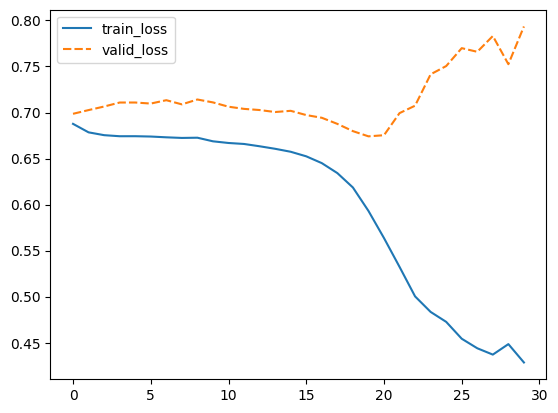

In [61]:
plot_loss(loss_train_hist, loss_valid_hist)

In [62]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.63542,0.44,0.711623,0.543779,0.711542


In [76]:
exclude_pos = [4, 5, 6, 7, 9, 13, 14, 15, 18, 20]  # constant positions

In [64]:
def process_seq(seq):
    reduce_seq = ''.join([seq[i] for i in range(len(seq)) if i not in exclude_pos])
    return reduce_seq

In [65]:
train_target['junction_aa'] = train_target['junction_aa'].apply(lambda x: process_seq(x))
valid_target['junction_aa'] = valid_target['junction_aa'].apply(lambda x: process_seq(x))
target_test['junction_aa'] = target_test['junction_aa'].apply(lambda x: process_seq(x))

/tmp/ipykernel_28529/3362057270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_test['junction_aa'] = target_test['junction_aa'].apply(lambda x: process_seq(x))


In [66]:
validloader = prepare_dataloader(valid_target, OnehotandAB, shuffle=True, batch_size=10)
testloader = prepare_dataloader(target_test, OnehotandAB, shuffle=True, batch_size=10)
trainloader_target = prepare_dataloader(train_target, OnehotandAB, shuffle=True, batch_size=10)

In [70]:
model = RNNembed(input_size=21, seq_lentgth=14, hidden_size=140, num_layers=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 50
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target,
                                                validloader)

100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


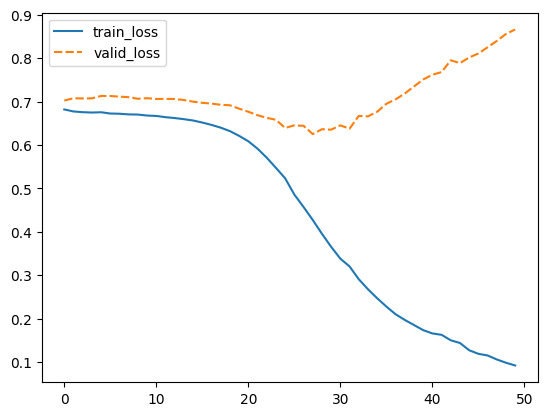

In [71]:
plot_loss(loss_train_hist, loss_valid_hist)

In [72]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.71309,0.649492,0.738059,0.690948,0.781186


Exclude constant positions increase model performance